### Import Dependencies

In [99]:
!unzip -q  /Plant_leaf_diseases_dataset_with_augmentation.zip

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [96]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

### Import Dataset

<b> Dataset Link (Plant Vliiage Dataset ):</b><br> <a href='https://data.mendeley.com/datasets/tywbtsjrjv/1'> https://data.mendeley.com/datasets/tywbtsjrjv/1 </a>

In [97]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [100]:
dataset = datasets.ImageFolder(
    "/content/Plant_leave_diseases_dataset_with_augmentation", transform=transform
)

In [101]:
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: /content/Plant_leave_diseases_dataset_with_augmentation
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [102]:
indices = list(range(len(dataset)))

In [103]:
split = int(np.floor(0.85 * len(dataset)))  # train_size

In [104]:
validation = int(np.floor(0.70 * split))  # validation

In [105]:
print(0, validation, split, len(dataset))

0 36584 52263 61486


In [106]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :36584
length of validation size :15679
length of test size :24902


In [107]:
np.random.shuffle(indices)

### Split into Train and Test

In [108]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

In [109]:
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [110]:
targets_size = len(dataset.class_to_idx)

### Model

<b>Convolution Aithmetic Equation : </b>(W - F + 2P) / S + 1 <br>
W = Input Size<br>
F = Filter Size<br>
P = Padding Size<br>
S = Stride <br>

### Transfer Learning

In [ ]:
# model = models.vgg16(pretrained=True)

In [ ]:
# for params in model.parameters():
#     params.requires_grad = False

In [ ]:
# model

In [ ]:
# n_features = model.classifier[0].in_features
# n_features

In [ ]:
# model.classifier = nn.Sequential(
#     nn.Linear(n_features, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(1024, targets_size),
# )

In [ ]:
# model

### Original Modeling

In [111]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [112]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check which GPU you got
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [35]:
#device = "cpu"

In [113]:
model = CNN(targets_size)

In [114]:
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [115]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [116]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [117]:
def batch_gd(model, criterion, train_loader, test_laoder, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [ ]:
#device = "cpu"

<IPython.core.display.Javascript object>

In [118]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [119]:
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)

Epoch : 1/5 Train_loss:2.215 Test_loss:1.366 Duration:0:05:00.107039
Epoch : 2/5 Train_loss:1.226 Test_loss:1.183 Duration:0:04:58.604215
Epoch : 3/5 Train_loss:0.982 Test_loss:0.999 Duration:0:04:57.607519
Epoch : 4/5 Train_loss:0.820 Test_loss:0.793 Duration:0:04:57.252764
Epoch : 5/5 Train_loss:0.660 Test_loss:0.725 Duration:0:04:57.682564


### Save the Model

In [120]:
torch.save(model.state_dict() , 'plant_disease_model_1.pt')

### Load Model

In [122]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("/content/plant_disease_model_1.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
# %matplotlib notebook

### Plot the loss

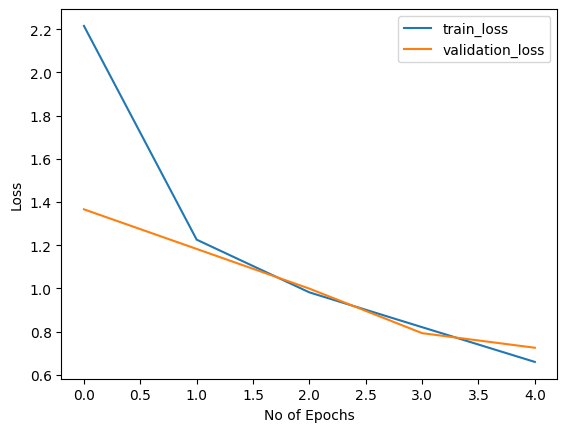

In [123]:
plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [124]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [125]:
# Before calculating accuracy, ensure model is on the same device as data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [126]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9163022086157884
Test Accuracy : 0.8871300010842459
Validation Accuracy : 0.8886408571975254


### Single Image Prediction

In [127]:
transform_index_to_disease = dataset.class_to_idx

In [128]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index

In [129]:
transform_index_to_disease

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Background_without_leaves',
 5: 'Blueberry___healthy',
 6: 'Cherry___Powdery_mildew',
 7: 'Cherry___healthy',
 8: 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 9: 'Corn___Common_rust',
 10: 'Corn___Northern_Leaf_Blight',
 11: 'Corn___healthy',
 12: 'Grape___Black_rot',
 13: 'Grape___Esca_(Black_Measles)',
 14: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 15: 'Grape___healthy',
 16: 'Orange___Haunglongbing_(Citrus_greening)',
 17: 'Peach___Bacterial_spot',
 18: 'Peach___healthy',
 19: 'Pepper,_bell___Bacterial_spot',
 20: 'Pepper,_bell___healthy',
 21: 'Potato___Early_blight',
 22: 'Potato___Late_blight',
 23: 'Potato___healthy',
 24: 'Raspberry___healthy',
 25: 'Soybean___healthy',
 26: 'Squash___Powdery_mildew',
 27: 'Strawberry___Leaf_scorch',
 28: 'Strawberry___healthy',
 29: 'Tomato___Bacterial_spot',
 30: 'Tomato___Early_blight',
 31: 'Tomato___Late_blight',
 32: 'Toma

In [130]:
data = pd.read_csv("/disease_info.csv", encoding="cp1252")

In [131]:
from PIL import Image
import torchvision.transforms.functional as TF

Original :  Apple___Apple_scab
Prediction: Strawberry___Leaf_scorch
Confidence: 82.84%


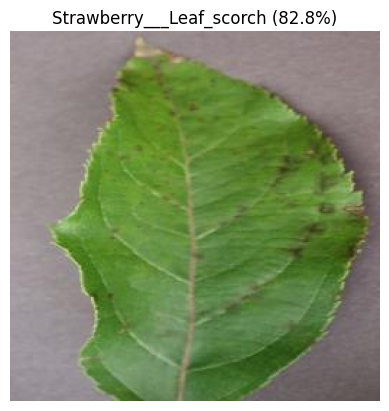

'Strawberry___Leaf_scorch'

In [150]:
def single_prediction(image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load and preprocess image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    predicted_idx = predicted.item()

    class_names = [
    'Apple___Apple_scab',
    'Apple___Black_rot',
    'Apple___Cedar_apple_rust',
    'Apple___healthy',
    'Blueberry___healthy',
    'Cherry_(including_sour)___Powdery_mildew',
    'Cherry_(including_sour)___healthy',
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
    'Corn_(maize)___Common_rust_',
    'Corn_(maize)___Northern_Leaf_Blight',
    'Corn_(maize)___healthy',
    'Grape___Black_rot',
    'Grape___Esca_(Black_Measles)',
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
    'Grape___healthy',
    'Orange___Haunglongbing_(Citrus_greening)',
    'Peach___Bacterial_spot',
    'Peach___healthy',
    'Pepper,_bell___Bacterial_spot',
    'Pepper,_bell___healthy',
    'Potato___Early_blight',
    'Potato___Late_blight',
    'Potato___healthy',
    'Raspberry___healthy',
    'Soybean___healthy',
    'Squash___Powdery_mildew',
    'Strawberry___Leaf_scorch',
    'Strawberry___healthy',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold',
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___healthy'
]



    # Safety check
    if predicted_idx >= len(class_names):
        print(f"ERROR: Predicted index {predicted_idx} is out of range!")
        print(f"class_names only has {len(class_names)} items")
        return None

    prediction = class_names[predicted_idx]
    confidence_score = confidence.item() * 100

    print("Original : ", image_path[56:-14])
    print(f"Prediction: {prediction}")
    print(f"Confidence: {confidence_score:.2f}%")

    # Display image
    plt.imshow(image)
    plt.title(f"{prediction} ({confidence_score:.1f}%)")
    plt.axis('off')
    plt.show()

    return prediction

# Test it
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Apple___Apple_scab/image (1).JPG")

Original :  Apple___Black_rot/i
Prediction: Apple___Black_rot
Confidence: 98.87%


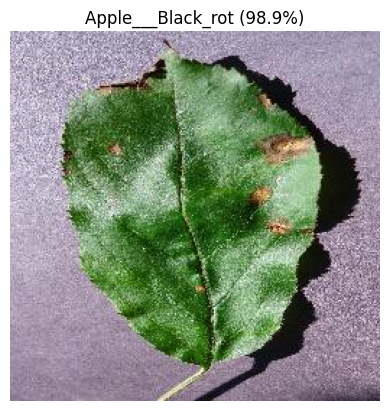

'Apple___Black_rot'

In [151]:


# Now test it
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Apple___Black_rot/image (100).JPG")

### Wrong Prediction

Original :  Apple___healthy/
Prediction: Apple___healthy
Confidence: 97.69%


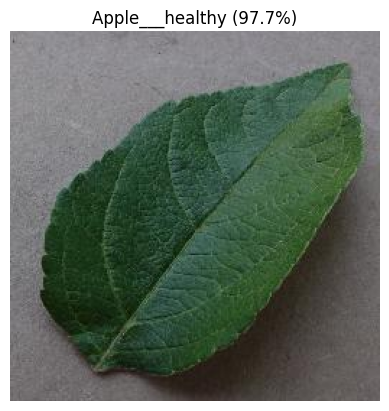

'Apple___healthy'

In [153]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Apple___healthy/image (10).JPG")

Original :  Corn___Common_rust/im
Prediction: Corn_(maize)___Northern_Leaf_Blight
Confidence: 100.00%


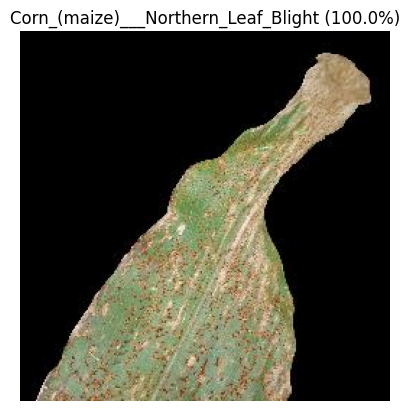

'Corn_(maize)___Northern_Leaf_Blight'

In [154]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Corn___Common_rust/image (1000).JPG")

Original :  Background_without_leaves
Prediction: Blueberry___healthy
Confidence: 100.00%


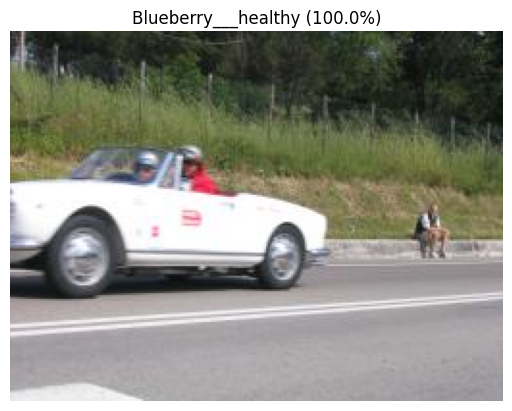

'Blueberry___healthy'

In [155]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Background_without_leaves/image (1).jpg")

Original :  Blueberry___healthy/im
Prediction: Cherry_(including_sour)___Powdery_mildew
Confidence: 96.26%


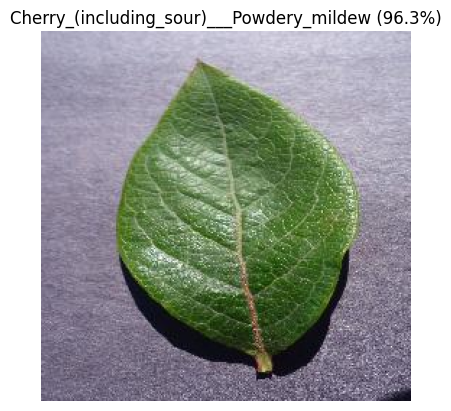

'Cherry_(including_sour)___Powdery_mildew'

In [157]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Blueberry___healthy/image (1000).JPG")

Original :  Cherry___Powdery_mildew/im
Prediction: Cherry_(including_sour)___healthy
Confidence: 99.98%


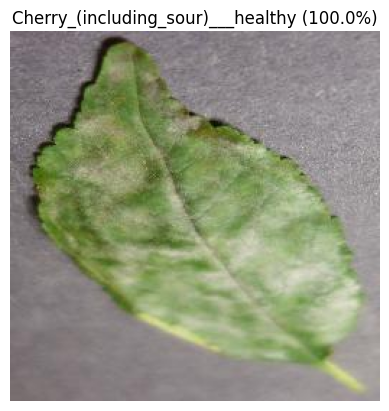

'Cherry_(including_sour)___healthy'

In [158]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Cherry___Powdery_mildew/image (1001).JPG")

Original :  Corn___Cercospora_leaf_spot Gray_leaf_spot/
Prediction: Corn_(maize)___Common_rust_
Confidence: 98.30%


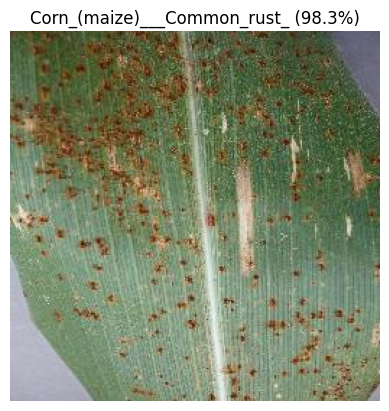

'Corn_(maize)___Common_rust_'

In [159]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Corn___Cercospora_leaf_spot Gray_leaf_spot/image (10).JPG")

Original :  Grape___healthy
Prediction: Orange___Haunglongbing_(Citrus_greening)
Confidence: 99.99%


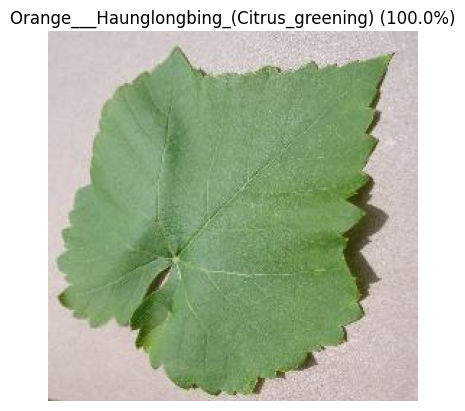

'Orange___Haunglongbing_(Citrus_greening)'

In [160]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Grape___healthy/image (1).JPG")

Original :  Orange___Haunglongbing_(Citrus_greening)/im
Prediction: Peach___Bacterial_spot
Confidence: 100.00%


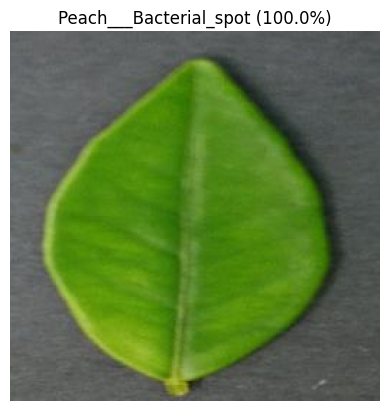

'Peach___Bacterial_spot'

In [161]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Orange___Haunglongbing_(Citrus_greening)/image (1006).JPG")

Original :  Soybean___healthy/
Prediction: Squash___Powdery_mildew
Confidence: 100.00%


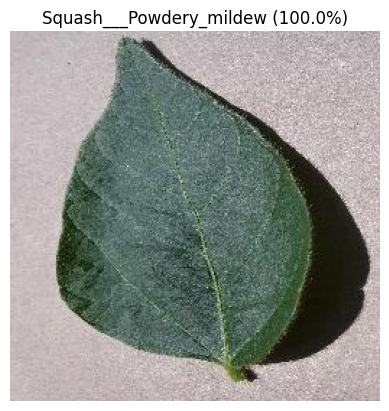

'Squash___Powdery_mildew'

In [162]:
single_prediction("/content/Plant_leave_diseases_dataset_with_augmentation/Soybean___healthy/image (10).JPG")

In [ ]:
single_prediction("test_images/corn_common_rust.JPG")

Original :  corn_common_rust
Corn : Common Rust


In [ ]:
single_prediction("test_images/corn_healthy.jpg")

Original :  corn_healthy
Corn : Healthy


In [ ]:
single_prediction("test_images/corn_northen_leaf_blight.JPG")

Original :  corn_northen_leaf_blight
Corn : Northern Leaf Blight


In [77]:
single_prediction("test_images/grape_black_rot.JPG")

Original :  grape_black_rot
Predicted index: 12
Predicted disease: Grape : Black Rot


'Grape : Black Rot'

In [78]:
single_prediction("test_images/grape_healthy.JPG")

Original :  grape_healthy
Predicted index: 12
Predicted disease: Grape : Black Rot


'Grape : Black Rot'

In [ ]:
single_prediction("test_images/grape_leaf_blight.JPG")

Original :  grape_leaf_blight
Grape : Leaf Blight | Isariopsis Leaf Spot


In [ ]:
single_prediction("test_images/orange_haunglongbing.JPG")

Original :  orange_haunglongbing
Orange : Haunglongbing | Citrus Greening


In [ ]:
single_prediction("test_images/peach_bacterial_spot.JPG")

Original :  peach_bacterial_spot
Peach : Bacterial Spot


In [ ]:
single_prediction("test_images/peach_healthy.JPG")

Original :  peach_healthy
Peach : Healthy


In [ ]:
single_prediction("test_images/pepper_bacterial_spot.JPG")

Original :  pepper_bacterial_spot
Pepper bell : Healthy


In [ ]:
single_prediction("test_images/pepper_bell_healthy.JPG")

Original :  pepper_bell_healthy
Pepper bell : Healthy


In [ ]:
single_prediction("test_images/potato_early_blight.JPG")

Original :  potato_early_blight
Potato : Early Blight


In [ ]:
single_prediction("test_images/potato_healthy.JPG")

Original :  potato_healthy
Potato : Healthy


In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [ ]:
single_prediction("test_images/raspberry_healthy.JPG")

Original :  raspberry_healthy
Raspberry : Healthy


In [ ]:
single_prediction("test_images/soyaben healthy.JPG")

Original :  soyaben healthy
Soybean : Healthy


In [ ]:
single_prediction("test_images/potato_late_blight.JPG")

Original :  potato_late_blight
Potato : Late Blight


In [ ]:
single_prediction("test_images/squash_powdery_mildew.JPG")

Original :  squash_powdery_mildew
Squash : Powdery Mildew


In [ ]:
single_prediction("test_images/starwberry_healthy.JPG")

Original :  starwberry_healthy
Strawberry : Healthy


In [ ]:
single_prediction("test_images/starwberry_leaf_scorch.JPG")

Original :  starwberry_leaf_scorch
Strawberry : Leaf Scorch


In [ ]:
single_prediction("test_images/tomato_bacterial_spot.JPG")

Original :  tomato_bacterial_spot
Tomato : Early Blight


In [ ]:
single_prediction("test_images/tomato_early_blight.JPG")

Original :  tomato_early_blight
Tomato : Early Blight


In [ ]:
single_prediction("test_images/tomato_healthy.JPG")

Original :  tomato_healthy
Tomato : Healthy


In [ ]:
single_prediction("test_images/tomato_late_blight.JPG")

Original :  tomato_late_blight
Tomato : Late Blight


In [ ]:
single_prediction("test_images/tomato_leaf_mold.JPG")

Original :  tomato_leaf_mold
Tomato : Leaf Mold


In [ ]:
single_prediction("test_images/tomato_mosaic_virus.JPG")

Original :  tomato_mosaic_virus
Tomato : Mosaic Virus


In [ ]:
single_prediction("test_images/tomato_septoria_leaf_spot.JPG")

Original :  tomato_septoria_leaf_spot
Tomato : Septoria Leaf Spot


In [ ]:
single_prediction("test_images/tomato_spider_mites_two_spotted_spider_mites.JPG")

Original :  tomato_spider_mites_two_spotted_spider_mites
Tomato : Spider Mites | Two-Spotted Spider Mite


In [ ]:
single_prediction("test_images/tomato_target_spot.JPG")

Original :  tomato_target_spot
Tomato : Target Spot


In [ ]:
single_prediction("test_images/tomato_yellow_leaf_curl_virus.JPG")

Original :  tomato_yellow_leaf_curl_virus
Tomato : Yellow Leaf Curl Virus
